In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [51]:
from keras.api._v2.keras.preprocessing.image import ImageDataGenerator
from keras.api._v2.keras.applications.vgg16 import VGG16
from keras.api._v2.keras.applications.vgg19 import VGG19
from keras.api._v2.keras.applications.resnet import ResNet50
from keras.api._v2.keras.applications.efficientnet import EfficientNetB3
from keras.api._v2.keras.applications.mobilenet_v2 import MobileNetV2
from keras.api._v2.keras.applications.xception import Xception
from keras.api._v2.keras.optimizers import Adam
from keras.api._v2.keras.callbacks import EarlyStopping
from keras.api._v2.keras.layers import Dense, LeakyReLU, Dropout, Flatten, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [3]:
from typing import Tuple, List

In [4]:
tf.get_logger().setLevel('WARNING')

In [53]:
def build_transfer_learning(classes: int,
                            architecture: str='vgg16',
                            add_layers: bool=True,
                            trainable: bool=True,
                            input_shape: Tuple[int,int,int]=(224,224,3)) -> keras.Model:
  model_arc = {
    'vgg16': VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape,
                   pooling='avg',
                   classes=None if add_layers else classes),
    'vgg19': VGG19(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape,
                   pooling='avg',
                   classes=None if add_layers else classes),
    'resnet50': ResNet50(include_top=False,
                         weights='imagenet',
                         input_shape=input_shape,
                         pooling='avg',
                         classes=None if add_layers else classes),
    'efficientnetb3': EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=input_shape,
                                     pooling='avg',
                                     classes=None if add_layers else classes),
    'mobilenetv2': MobileNetV2(include_top=False,
                               weights='imagenet',
                               input_shape=input_shape,
                               pooling='avg',
                               classes=None if add_layers else classes),
    'xception': Xception(include_top=False,
                         weights='imagenet',
                         input_shape=input_shape,
                         pooling='avg',
                         classes=None if add_layers else classes)}
  pretrained = model_arc.get(architecture, model_arc['vgg16'])
  
  if not add_layers:
    model = tf.keras.Model(
      inputs=pretrained.input,
      outputs=Dense(classes, activation='softmax')(pretrained.output))
    model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    return model

  pretrained.trainable = trainable

  input_layer = pretrained.input
  
  net = Dense(2048, activation='swish')(pretrained.output)
  net = Dropout(0.2)(net)
  net = Dense(1024, activation='swish')(net)
  net = Dropout(0.1)(net)
    
  output_layer = Dense(classes, activation='softmax')(net)
  
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [6]:
def load_df(filepaths: str) -> Tuple[pd.DataFrame, List[str]]:
  labels = [str(filepaths[i]).split('\\')[-2] for i in range(len(filepaths))]
  df_labels, labels = labels, sorted(list(set(labels)))
  df_path = pd.Series(filepaths, name='Path').astype(str)
  df_labels = pd.Series(df_labels, name='Label')
  
  df = pd.concat([df_path, df_labels], axis=1)
  df = df.sample(frac=1).reset_index(drop=True)

  return df, labels

In [7]:
def train_valid_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
  labels = df.Label.unique().tolist()
  dfs_train, dfs_valid = [], []
  
  for label in labels:
    temp_df = df[df.Label == label]
    df_train, df_valid = train_test_split(temp_df, test_size=0.2)
    dfs_train.append(df_train)
    dfs_valid.append(df_valid)

  return pd.concat(dfs_train).sample(frac=1).reset_index(drop=True),\
    pd.concat(dfs_valid).sample(frac=1).reset_index(drop=True)

In [8]:
train_dir = Path('../data/train')
train_fp = list(train_dir.glob(r'**/*.*'))

test_dir = Path('../data/test/')
test_fp = list(test_dir.glob(r'**/*.*'))

In [9]:
df_train, labels = load_df(train_fp)
df_test, _ = load_df(test_fp)
df_train, df_valid = train_valid_split(df_train)

In [ ]:
print(df_test.Label.unique())
print(df_train.Label.unique())
print(df_valid.Label.unique())

In [10]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                             height_shift_range=0.2, rescale=1./255,
                             shear_range=0.1, zoom_range=0.2,
                             horizontal_flip=True, vertical_flip=True,
                             fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)

In [58]:
dataset_train = datagen.flow_from_dataframe(
  dataframe=df_train,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=4,
  shuffle=True,
  seed=0)

dataset_valid = datagen.flow_from_dataframe(
  dataframe=df_valid,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=4,
  shuffle=True,
  seed=0)

dataset_test = datagen_test.flow_from_dataframe(
  dataframe=df_test,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=4,
  shuffle=False)

Found 880 validated image filenames belonging to 11 classes.
Found 220 validated image filenames belonging to 11 classes.
Found 110 validated image filenames belonging to 11 classes.


In [54]:
model = build_transfer_learning(classes=len(labels),
                                architecture='vgg19',
                                input_shape=(224,224,3))
# model.summary()

80134624/80134624 [==============================] - 71s 1us/step


In [ ]:
tf.keras.utils.plot_model(model,
                          show_layer_names=False,
                          show_shapes=True,
                          show_layer_activations=True)

In [60]:
history = model.fit(dataset_train,
                    validation_data=dataset_valid,
                    batch_size=8,
                    epochs=15,
                    callbacks=[
                      EarlyStopping(
                        monitor='val_loss',
                        patience=3,
                        restore_best_weights=True)])

Epoch 1/15
220/220 [==============================] - 36s 163ms/step - loss: 2.4074 - accuracy: 0.0739 - val_loss: 2.4006 - val_accuracy: 0.0909
Epoch 2/15
220/220 [==============================] - 37s 167ms/step - loss: 2.4075 - accuracy: 0.0750 - val_loss: 2.3994 - val_accuracy: 0.0909
Epoch 3/15
220/220 [==============================] - 36s 164ms/step - loss: 2.4051 - accuracy: 0.0852 - val_loss: 2.4016 - val_accuracy: 0.0909
Epoch 4/15
220/220 [==============================] - 37s 169ms/step - loss: 2.4074 - accuracy: 0.0739 - val_loss: 2.3987 - val_accuracy: 0.0909
Epoch 5/15
220/220 [==============================] - 35s 160ms/step - loss: 2.4051 - accuracy: 0.0739 - val_loss: 2.3996 - val_accuracy: 0.0909
Epoch 6/15
220/220 [==============================] - 38s 171ms/step - loss: 2.4051 - accuracy: 0.0773 - val_loss: 2.3989 - val_accuracy: 0.0909
Epoch 7/15
220/220 [==============================] - 36s 166ms/step - loss: 2.4032 - accuracy: 0.0886 - val_loss: 2.4201 - val_ac

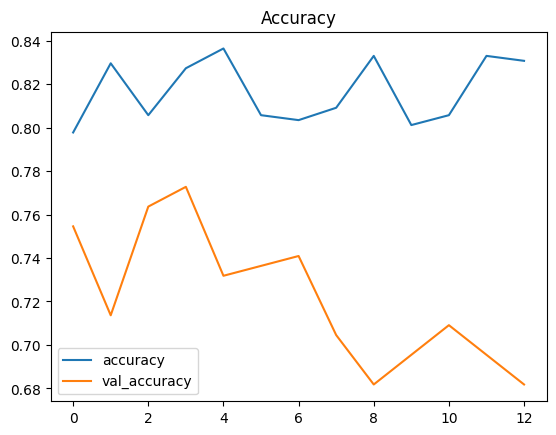

In [23]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy'); plt.show()

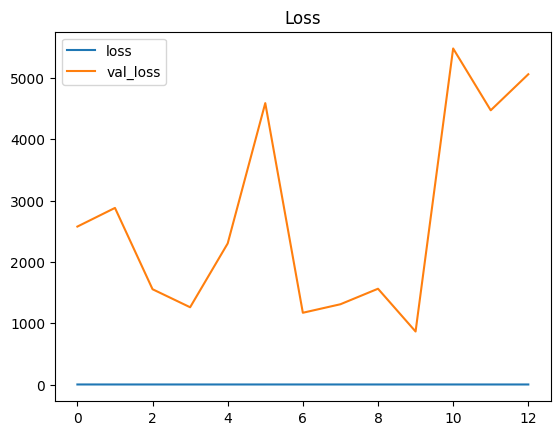

In [24]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss'); plt.show()

In [46]:
pred = model.predict(dataset_test)
pred = np.argmax(pred, axis=1)

gen_labels = (dataset_train.class_indices)
gen_labels = dict((v,k) for k,v in gen_labels.items())
pred = [gen_labels[k] for k in pred]
y_test = [gen_labels[k] for k in dataset_test.classes]

28/28 [==============================] - 2s 85ms/step


In [36]:
gen_labels

{0: 'apple',
 1: 'banana',
 2: 'dragonfruit',
 3: 'durian',
 4: 'lemon',
 5: 'lime',
 6: 'mango',
 7: 'orange',
 8: 'peach',
 9: 'pear',
 10: 'pineapple'}

In [35]:
np.unique(pred)

array(['apple', 'banana', 'dragonfruit', 'durian', 'lemon', 'lime',
       'mango', 'orange', 'peach', 'pear', 'pineapple'], dtype='<U11')

In [47]:
print(classification_report(y_test, pred, digits=3, zero_division=0.0))

              precision    recall  f1-score   support

       apple      0.455     0.500     0.476        10
      banana      0.692     0.900     0.783        10
 dragonfruit      0.333     0.300     0.316        10
      durian      0.900     0.900     0.900        10
       lemon      0.909     1.000     0.952        10
        lime      1.000     0.800     0.889        10
       mango      0.667     0.400     0.500        10
      orange      0.769     1.000     0.870        10
       peach      0.889     0.800     0.842        10
        pear      0.833     1.000     0.909        10
   pineapple      1.000     0.800     0.889        10

    accuracy                          0.764       110
   macro avg      0.768     0.764     0.757       110
weighted avg      0.768     0.764     0.757       110



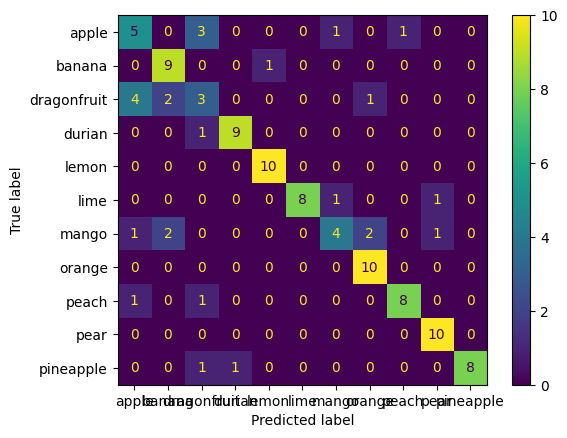

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [40]:
model.save('models/baseline_cnn_model_xception_5', include_optimizer=True)

In [41]:
import pickle

f = open('dict_softmax/baseline_cnn_model_xception_5.pkl', 'wb')
pickle.dump(gen_labels, f)
f.close()